# **Predicción y Modelado de la Calidad del Aire en Madrid Integrando Datos Meteorológicos, Contaminantes y Tráfico**

## **💡 Introducción**

El presente proyecto aborda el análisis y modelado de la calidad del aire en la ciudad de Madrid, integrando datos históricos de contaminantes atmosféricos, variables meteorológicas y registros de tráfico. A través de un riguroso proceso de limpieza, transformación y enriquecimiento de datos, se construye un índice de calidad del aire (AQI) ajustado que refleja de manera más precisa el impacto de factores ambientales y urbanos sobre la salud pública.

El objetivo principal es desarrollar un modelo predictivo robusto que permita anticipar los niveles de AQI en diferentes zonas y fechas, facilitando la toma de decisiones informadas para la gestión ambiental y la planificación urbana. Para ello, se emplean técnicas avanzadas de análisis de datos, ingeniería de variables y machine learning, asegurando la trazabilidad y reproducibilidad de cada etapa del flujo de trabajo.

Este enfoque integral proporciona una herramienta valiosa para autoridades, investigadores y ciudadanos interesados en comprender y mitigar los efectos de la contaminación atmosférica en entornos urbanos complejos.

##**📘 Instalación de las librerias**
En esta sección se realiza la importación de las librerías necesarias para el análisis y modelado de datos. Se incluyen herramientas para manipulación y visualización de datos (`pandas`, `numpy`, `matplotlib`, `seaborn`), manejo de archivos y widgets interactivos (`io`, `os`, `folium`, `ipywidgets`), así como módulos especializados para machine learning y preprocesamiento (`scikit-learn`, `xgboost`). Estas librerías permiten realizar desde la limpieza y transformación de datos hasta la construcción y evaluación de modelos predictivos, asegurando un flujo de trabajo eficiente y reproducible.

In [ ]:
!pip install google-cloud-storage

In [ ]:
!pip install folium ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.5 MB/s eta 0:00:00


In [ ]:
from google.cloud import storage
from google.colab import files

In [ ]:

    storage_client = storage.Client()

In [ ]:
# Manipulación de datos
import numpy as np
import pandas as pd
from io import BytesIO
import os
import folium
from folium.plugins import MarkerCluster
from ipywidgets import interact, widgets
from IPython.display import display, clear_output

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesamiento y machine learning (scikit-learn)
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# Modelos supervisados más comunes
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

# Configuración de visualizaciones
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

##**🧹 Inserción, visualización y limpieza de los datos**

In [ ]:


En este apartado se realiza la carga y unificación de los archivos de datos meteorológicos y de contaminantes, así como su limpieza y transformación para el análisis posterior. Los pasos principales son:

- **Carga y unión de archivos:** Se leen múltiples archivos CSV de diferentes años y se concatenan en un único DataFrame (`df_unido`).
- **Exploración inicial:** Se inspeccionan las columnas, tipos de datos y valores únicos, especialmente de la columna `MAGNITUD`.
- **Mapeo de códigos:** Se asignan nombres descriptivos a los códigos de magnitudes y estaciones, facilitando la interpretación.
- **Filtrado:** Se eliminan magnitudes y columnas no relevantes para el análisis.
- **Transformación de formato:** Se reorganizan los datos de formato ancho a largo, creando una columna de fecha a partir de año, mes y día.
- **Asignación de zonas:** Se asignan zonas geográficas a cada estación, completando los valores faltantes mediante diccionarios auxiliares.
- **Resumen y agregación:** Se agrupan los datos por zona, fecha y magnitud, calculando estadísticas como media, máximo y mínimo.
- **Exportación:** El DataFrame resultante (`df_resumen`) se guarda para su uso en etapas posteriores del análisis.

Este proceso garantiza que los datos estén limpios, estructurados y listos para el modelado y la visualización.

In [ ]:
# Lista con los nombres de los archivos
archivos = ['meteo21.csv', 'meteo22.csv', 'meteo23.csv', 'meteo24.csv', 'meteo25.csv', 'datos2021.csv', 'datos2022.csv', 'datos2023.csv', 'datos2024.csv', 'datos2025.csv']

# Leer y unir todos los archivos CSV
dataframes = []
for archivo in archivos:
    df = pd.read_csv(archivo, sep=';')  # separador ;
    dataframes.append(df)

# Unir todos los DataFrames en uno solo
df_unido = pd.concat(dataframes, ignore_index=True)

# Mostrar primeras filas para verificar
print(df_unido.head())

   PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD  PUNTO_MUESTREO   ANO  MES   D01  \
0         28         79       102        81  28079102_81_98  2021    1  2.21   
1         28         79       102        81  28079102_81_98  2021    2  3.09   
2         28         79       102        81  28079102_81_98  2021    3  2.61   
3         28         79       102        81  28079102_81_98  2021    4  2.52   
4         28         79       102        81  28079102_81_98  2021    5  1.27   

  V01   D02  ...   D27  V27   D28  V28   D29  V29   D30  V30   D31  V31  
0   V  1.48  ...  1.04    V  0.63    V  0.94    V  4.20    V  3.81    V  
1   V  2.32  ...  1.48    V  3.11    V  0.00    N  0.00    N  0.00    N  
2   V  1.54  ...  2.39    V  2.70    V  2.96    V  3.09    V  2.95    V  
3   V  1.45  ...  1.28    V  1.92    V  3.10    V  1.77    V  0.00    N  
4   V  2.01  ...  1.97    V  1.99    V  1.47    V  2.84    V  2.52    V  

[5 rows x 69 columns]


In [ ]:
df_unido.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10848 entries, 0 to 10847
Data columns (total 70 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   PROVINCIA        10848 non-null  int64  
 1   MUNICIPIO        10848 non-null  int64  
 2   ESTACION         10848 non-null  int64  
 3   MAGNITUD         10848 non-null  int64  
 4   PUNTO_MUESTREO   10848 non-null  object 
 5   ANO              10848 non-null  int64  
 6   MES              10848 non-null  int64  
 7   D01              10848 non-null  float64
 8   V01              10848 non-null  object 
 9   D02              10848 non-null  float64
 10  V02              10848 non-null  object 
 11  D03              10848 non-null  float64
 12  V03              10848 non-null  object 
 13  D04              10848 non-null  float64
 14  V04              10848 non-null  object 
 15  D05              10848 non-null  float64
 16  V05              10848 non-null  object 
 17  D06         

In [ ]:
# Obtener los valores únicos de las columnas 'ESTACION' y 'MAGNITUD'

magnitudes_unicas = df_unido['MAGNITUD'].unique()

# Imprimir los valores únicos

print("\nValores únicos de la columna 'MAGNITUD':", magnitudes_unicas)



Valores únicos de la columna 'MAGNITUD': [81 82 83 86 87 88 89  1  6  7  8 12  9 10 14 20 30 35 42 43 44]


In [ ]:
# Diccionario de códigos y nombres de magnitudes
codigo_a_nombre = {
    81: "Viento",
    82: "Dir. Viento",
    83: "Temperatura",
    86: "Humedad Rel.",
    87: "Presión Baro.",
    88: "Radiación Solar",
    89: "Precipitación",
    1: "SO2",
    6: "CO",
    7: "NO",
    8: "NO2",
    9: "MP2,5",
    10: "MP10",
    12: "O.NITRO",
    14: "O3",
    20: "TOL",
    30: "BEN",
    35: "EBE"
}

# Crear nueva columna con los nombres
df_unido["Nombre_Magnitud"] = df_unido["MAGNITUD"].map(codigo_a_nombre)

# Verificar resultado
print(df_unido[["MAGNITUD", "Nombre_Magnitud"]].drop_duplicates().sort_values("MAGNITUD"))


      MAGNITUD  Nombre_Magnitud
4423         1              SO2
4433         6               CO
4443         7               NO
4453         8              NO2
4521         9            MP2,5
4533        10             MP10
4463        12          O.NITRO
4557        14               O3
4569        20              TOL
4581        30              BEN
4593        35              EBE
4605        42              NaN
4606        43              NaN
4607        44              NaN
0           81           Viento
12          82      Dir. Viento
24          83      Temperatura
36          86     Humedad Rel.
48          87    Presión Baro.
60          88  Radiación Solar
72          89    Precipitación


In [ ]:
# Lista de códigos que quieres eliminar
codigos_a_eliminar = [20, 30, 35, 12, 7, 88, 82, 42, 43, 44]

# Filtrar el DataFrame para eliminar esos códigos
df_filtrado = df_unido[~df_unido["MAGNITUD"].isin(codigos_a_eliminar)].copy()

# Crear la columna con los nombres de magnitudes
codigo_a_nombre = {
    81: "Viento",
    83: "Temperatura",
    86: "Humedad Rel.",
    87: "Presión Baro.",
    89: "Precipitación",
    1: "SO2",
    6: "CO",
    8: "NO2",
    9: "PM2,5",
    10: "PM10",
    14: "O3"
}

df_filtrado["Nombre_Magnitud"] = df_filtrado["MAGNITUD"].map(codigo_a_nombre)

# Mostrar para verificar
print(df_filtrado[["MAGNITUD", "Nombre_Magnitud"]].drop_duplicates().sort_values("MAGNITUD"))


      MAGNITUD Nombre_Magnitud
4423         1             SO2
4433         6              CO
4453         8             NO2
4521         9           PM2,5
4533        10            PM10
4557        14              O3
0           81          Viento
24          83     Temperatura
36          86    Humedad Rel.
48          87   Presión Baro.
72          89   Precipitación


In [ ]:
# recuento de filas de df_filtrado

print(f"Número de filas en df_filtrado: {len(df_filtrado)}")


Número de filas en df_filtrado: 6810


In [ ]:
lista_columnas = df_filtrado.columns.tolist()
print(lista_columnas)

['PROVINCIA', 'MUNICIPIO', 'ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'D01', 'V01', 'D02', 'V02', 'D03', 'V03', 'D04', 'V04', 'D05', 'V05', 'D06', 'V06', 'D07', 'V07', 'D08', 'V08', 'D09', 'V09', 'D10', 'V10', 'D11', 'V11', 'D12', 'V12', 'D13', 'V13', 'D14', 'V14', 'D15', 'V15', 'D16', 'V16', 'D17', 'V17', 'D18', 'V18', 'D19', 'V19', 'D20', 'V20', 'D21', 'V21', 'D22', 'V22', 'D23', 'V23', 'D24', 'V24', 'D25', 'V25', 'D26', 'V26', 'D27', 'V27', 'D28', 'V28', 'D29', 'V29', 'D30', 'V30', 'D31', 'V31', 'Nombre_Magnitud']


In [ ]:
# Eliminar columnas 'V*' y también 'PROVINCIA' y 'MUNICIPIO'
columnas_a_eliminar = [col for col in df_filtrado.columns if col.startswith('V') and col[1:].isdigit()]
columnas_a_eliminar += ['PROVINCIA', 'MUNICIPIO']

# Eliminar las columnas del DataFrame
df_filtrado = df_filtrado.drop(columns=columnas_a_eliminar)

# Verificar columnas restantes
print(df_filtrado.columns)



Index(['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'D01', 'D02',
       'D03', 'D04', 'D05', 'D06', 'D07', 'D08', 'D09', 'D10', 'D11', 'D12',
       'D13', 'D14', 'D15', 'D16', 'D17', 'D18', 'D19', 'D20', 'D21', 'D22',
       'D23', 'D24', 'D25', 'D26', 'D27', 'D28', 'D29', 'D30', 'D31',
       'Nombre_Magnitud'],
      dtype='object')


In [ ]:
# Reorganizar de ancho a largo
df_largo = df_filtrado.melt(
    id_vars=['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES', 'Nombre_Magnitud'],
    value_vars=[col for col in df_filtrado.columns if col.startswith('D')],
    var_name='DIA_COL',
    value_name='VALOR'
)

# Extraer número de día y convertir a entero
df_largo['DIA'] = df_largo['DIA_COL'].str.extract(r'D(\d{1,2})')  # Extrae los números de 'D01', 'D02', etc.
df_largo['DIA'] = pd.to_numeric(df_largo['DIA'], errors='coerce').astype('Int64')

# Asegúrate de que AÑO y MES estén en formato entero
df_largo['ANO'] = pd.to_numeric(df_largo['ANO'], errors='coerce').astype('Int64')
df_largo['MES'] = pd.to_numeric(df_largo['MES'], errors='coerce').astype('Int64')

# Verifica columnas disponibles
print("Columnas disponibles:", df_largo.columns)

# Crear columna de fecha (solo si no hay valores faltantes)
df_largo = df_largo.dropna(subset=['ANO', 'MES', 'DIA'])  # Elimina filas incompletas
df_largo['FECHA'] = pd.to_datetime(
    df_largo[['ANO', 'MES', 'DIA']].rename(columns={'ANO': 'year', 'MES': 'month', 'DIA': 'day'}),
    errors='coerce'
)

# Eliminar columnas temporales
df_largo = df_largo.drop(columns=['DIA_COL', 'ANO', 'MES', 'DIA'])

# Reorganizar columnas
df_largo = df_largo[['FECHA', 'ESTACION', 'MAGNITUD', 'Nombre_Magnitud', 'PUNTO_MUESTREO', 'VALOR']]

# Verifica
print(df_largo.head(100))
print(df_largo.shape)
print(df_largo.columns)
print(df_largo.info())





Columnas disponibles: Index(['ESTACION', 'MAGNITUD', 'PUNTO_MUESTREO', 'ANO', 'MES',
       'Nombre_Magnitud', 'DIA_COL', 'VALOR', 'DIA'],
      dtype='object')
        FECHA  ESTACION  MAGNITUD Nombre_Magnitud  PUNTO_MUESTREO   VALOR
0  2021-01-01       102        81          Viento  28079102_81_98    2.21
1  2021-02-01       102        81          Viento  28079102_81_98    3.09
2  2021-03-01       102        81          Viento  28079102_81_98    2.61
3  2021-04-01       102        81          Viento  28079102_81_98    2.52
4  2021-05-01       102        81          Viento  28079102_81_98    1.27
..        ...       ...       ...             ...             ...     ...
95 2021-12-01       103        86    Humedad Rel.  28079103_86_98   81.00
96 2021-01-01       103        87   Presión Baro.  28079103_87_98  943.00
97 2021-02-01       103        87   Presión Baro.  28079103_87_98  947.00
98 2021-03-01       103        87   Presión Baro.  28079103_87_98  951.00
99 2021-04-01       103  

In [ ]:
# Diccionario de códigos de estación a nombres
codigo_estacion_nombre = {
    '28079102': 'J.M.D. Moratalaz',
    '28079103': 'J.M.D. Villaverde',
    '28079104': 'E.D.A.R. La China',
    '28079106': 'Centro Mpal. De Acústica',
    '28079107': 'J.M.D. Hortaleza',
    '28079108': 'Peñagrande',
    '28079109': 'J.M.D. Chamberí',
    '28079110': 'J.M.D. Centro',
    '28079111': 'J.M.D. Chamartin',
    '28079112': 'J.M.D. Vallecas 1',
    '28079113': 'J.M.D. Vallecas 2',
    '28079114': 'Matadero 01',
    '28079115': 'Matadero 02',
    '28079004': 'Plaza España',
    '28079008': 'Escuelas Aguirre',
    '28079016': 'Arturo Soria',
    '28079018': 'Farolillo',
    '28079024': 'Casa de Campo',
    '28079035': 'Plaza del Carmen',
    '28079036': 'Moratalaz',
    '28079038': 'Cuatro Caminos',
    '28079039': 'Barrio del Pilar',
    '28079054': 'Ensanche de Vallecas',
    '28079056': 'Plaza Elíptica',
    '28079058': 'El Pardo',
    '28079059': 'Juan Carlos I'
}

# Extraer los primeros 8 caracteres del código de muestreo
df_largo['CODIGO_ESTACION'] = df_largo['PUNTO_MUESTREO'].str[:8]

# Mapear el nombre de la estación
df_largo['NOMBRE_ESTACION'] = df_largo['CODIGO_ESTACION'].map(codigo_estacion_nombre)

# Verificar
print(df_largo[['PUNTO_MUESTREO', 'CODIGO_ESTACION', 'NOMBRE_ESTACION']].drop_duplicates().head())


    PUNTO_MUESTREO CODIGO_ESTACION   NOMBRE_ESTACION
0   28079102_81_98        28079102  J.M.D. Moratalaz
12  28079102_83_98        28079102  J.M.D. Moratalaz
24  28079102_86_98        28079102  J.M.D. Moratalaz
36  28079102_87_98        28079102  J.M.D. Moratalaz
48  28079102_89_98        28079102  J.M.D. Moratalaz


In [ ]:
df_largo = df_largo.drop(columns=['PUNTO_MUESTREO'])
print(df_largo.columns)


Index(['FECHA', 'ESTACION', 'MAGNITUD', 'Nombre_Magnitud', 'VALOR',
       'CODIGO_ESTACION', 'NOMBRE_ESTACION'],
      dtype='object')


In [ ]:
estacion_zona = {
    # Zona 01 (Interior M-30)
    'Barrio del Pilar': 'Zona 01 (Interior M-30)',
    'Cuatro Caminos': 'Zona 01 (Interior M-30)',
    'Escuelas Aguirre': 'Zona 01 (Interior M-30)',
    'Plaza España': 'Zona 01 (Interior M-30)',
    'Plaza del Carmen': 'Zona 01 (Interior M-30)',
    'Peñagrande': 'Zona 01 (Interior M-30)',
    'J.M.D. Chamberí': 'Zona 01 (Interior M-30)',
    'J.M.D. Centro': 'Zona 01 (Interior M-30)',
    'J.M.D. Chamartin': 'Zona 01 (Interior M-30)',
    'Matadero 02': 'Zona 01 (Interior M-30)',

    # Zona 02 (Sureste)
    'Ensanche de Vallecas': 'Zona 02 (Sureste)',
    'Moratalaz': 'Zona 02 (Sureste)',
    'J.M.D. Vallecas 1': 'Zona 02 (Sureste)',
    'J.M.D. Vallecas 2': 'Zona 02 (Sureste)',
    'J.M.D. Moratalaz': 'Zona 02 (Sureste)',
    'E.D.A.R. La China': 'Zona 02 (Sureste)',
    'Matadero 01': 'Zona 02 (Sureste)',

    # Zona 03 (Noreste)
    'Arturo Soria': 'Zona 03 (Noreste)',
    'Juan Carlos I': 'Zona 03 (Noreste)',
    'J.M.D. Hortaleza': 'Zona 03 (Noreste)',

    # Zona 04 (Noroeste)
    'Casa de Campo': 'Zona 04 (Noroeste)',
    'El Pardo': 'Zona 04 (Noroeste)',
    'Centro Mpal. De Acústica': 'Zona 04 (Noroeste)',

    # Zona 05 (Suroeste)
    'Farolillo': 'Zona 05 (Suroeste)',
    'Plaza Elíptica': 'Zona 05 (Suroeste)',
    'J.M.D. Villaverde': 'Zona 05 (Suroeste)',
}


In [ ]:
df_largo['ZONA'] = df_largo['NOMBRE_ESTACION'].map(estacion_zona)

# Opcional: revisar si aún quedan estaciones sin zona
zonas_faltantes = df_largo[df_largo['ZONA'].isna()]['NOMBRE_ESTACION'].unique()
print("Estaciones sin zona asignada:", zonas_faltantes)



Estaciones sin zona asignada: [nan]


In [ ]:
# Encuentra todas las filas donde 'NOMBRE_ESTACION' es NaN
nan_rows = df_largo[df_largo['NOMBRE_ESTACION'].isna()]

# Imprime las filas
nan_rows


FECHA  ESTACION  MAGNITUD Nombre_Magnitud  VALOR CODIGO_ESTACION  \
3673   2021-01-01        11         8             NO2   17.0        28079011   
3674   2021-02-01        11         8             NO2   22.0        28079011   
3675   2021-03-01        11         8             NO2   33.0        28079011   
3676   2021-04-01        11         8             NO2   15.0        28079011   
3677   2021-05-01        11         8             NO2   18.0        28079011   
...           ...       ...       ...             ...    ...             ...   
211105        NaT        60         9           PM2,5    0.0        28079060   
211106 2025-01-31        60        10            PM10   11.0        28079060   
211107        NaT        60        10            PM10    0.0        28079060   
211108 2025-01-31        60        14              O3   46.0        28079060   
211109        NaT        60        14              O3    0.0        28079060   

       NOMBRE_ESTACION ZONA  
3673               NaN  NaN  
3674               NaN  NaN  
3675               NaN  NaN  
3676               NaN  NaN  
3677               NaN  NaN  
...                ...  ...  
211105             NaN  NaN  
211106             NaN  NaN  
211107             NaN  NaN  
211108             NaN  NaN  
211109             NaN  NaN  

[39990 rows x 8 columns]

In [ ]:
# prompt: valores unicos de las estaciones que en 'NOMBRE_ESTACION' TIENEN [nan]

# Encuentra las estaciones únicas donde 'NOMBRE_ESTACION' es NaN
estaciones_con_nan = nan_rows['ESTACION'].unique()

# Imprime las estaciones únicas
estaciones_con_nan


array([11, 17, 27, 40, 47, 48, 49, 50, 55, 57, 60])

In [ ]:
codigo_nombre = {
    '28079011': 'Av. Ramón y Cajal',
    '28079017': 'Villaverde Alto',
    '28079027': 'Barajas',
    '28079040': 'Vallecas',
    '28079047': 'Méndez Álvaro',
    '28079048': 'Po. Castellana',
    '28079049': 'Retiro',
    '28079050': 'Pza. Castilla',
    '28079055': 'Urb. Embajada (Barajas)',
    '28079057': 'Sanchinarro',
    '28079060': 'Tres Olivos'
}


In [ ]:
codigo_zona = {
    '28079011': 'Zona 01 (Interior M-30)',
    '28079017': 'Zona 05 (Suroeste)',
    '28079027': 'Zona 03 (Noreste)',
    '28079040': 'Zona 02 (Sureste)',
    '28079047': 'Zona 01 (Interior M-30)',
    '28079048': 'Zona 01 (Interior M-30)',
    '28079049': 'Zona 01 (Interior M-30)',
    '28079050': 'Zona 01 (Interior M-30)',
    '28079055': 'Zona 03 (Noreste)',
    '28079057': 'Zona 03 (Noreste)',
    '28079060': 'Zona 03 (Noreste)'
}


In [ ]:
# Asegurarse de que los códigos estén como string para evitar errores
df_largo['CODIGO_ESTACION'] = df_largo['CODIGO_ESTACION'].astype(str)

# Completar nombre de estación si está vacío
df_largo['NOMBRE_ESTACION'] = df_largo.apply(
    lambda row: codigo_nombre[row['CODIGO_ESTACION']] if pd.isna(row['NOMBRE_ESTACION']) and row['CODIGO_ESTACION'] in codigo_nombre else row['NOMBRE_ESTACION'],
    axis=1
)

# Completar zona si está vacía
df_largo['ZONA'] = df_largo.apply(
    lambda row: codigo_zona[row['CODIGO_ESTACION']] if pd.isna(row['ZONA']) and row['CODIGO_ESTACION'] in codigo_zona else row['ZONA'],
    axis=1
)


In [ ]:
faltantes = df_largo[df_largo['ZONA'].isna() | df_largo['NOMBRE_ESTACION'].isna()]
print("Filas aún sin nombre o zona asignada:", faltantes[['CODIGO_ESTACION', 'NOMBRE_ESTACION', 'ZONA']].drop_duplicates())


Filas aún sin nombre o zona asignada: Empty DataFrame
Columns: [CODIGO_ESTACION, NOMBRE_ESTACION, ZONA]
Index: []


In [ ]:
# Agrupamos por zona, fecha y magnitud
df_resumen = df_largo.groupby(['ZONA', 'FECHA', 'Nombre_Magnitud'])['VALOR'].agg(
    MEDIA='mean',
    MAXIMO='max',
    MINIMO='min'
).reset_index()


In [ ]:
# Mostrar primeras filas
print(df_resumen.head())
print(df_resumen.shape)
print(df_resumen.columns)
print(df_resumen.info())


                      ZONA      FECHA Nombre_Magnitud      MEDIA  MAXIMO  \
0  Zona 01 (Interior M-30) 2021-01-01              CO   0.225000     0.3   
1  Zona 01 (Interior M-30) 2021-01-01    Humedad Rel.  66.888889    74.0   
2  Zona 01 (Interior M-30) 2021-01-01             NO2  15.400000    23.0   
3  Zona 01 (Interior M-30) 2021-01-01              O3  55.250000    61.0   
4  Zona 01 (Interior M-30) 2021-01-01            PM10   4.600000     7.0   

   MINIMO  
0     0.2  
1    60.0  
2    10.0  
3    51.0  
4     3.0  
(72338, 6)
Index(['ZONA', 'FECHA', 'Nombre_Magnitud', 'MEDIA', 'MAXIMO', 'MINIMO'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72338 entries, 0 to 72337
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ZONA             72338 non-null  object        
 1   FECHA            72338 non-null  datetime64[ns]
 2   Nombre_Magnitud  72338 non-null  object       

In [ ]:
print(df_resumen.head(200))

                        ZONA      FECHA Nombre_Magnitud      MEDIA  MAXIMO  \
0    Zona 01 (Interior M-30) 2021-01-01              CO   0.225000    0.30   
1    Zona 01 (Interior M-30) 2021-01-01    Humedad Rel.  66.888889   74.00   
2    Zona 01 (Interior M-30) 2021-01-01             NO2  15.400000   23.00   
3    Zona 01 (Interior M-30) 2021-01-01              O3  55.250000   61.00   
4    Zona 01 (Interior M-30) 2021-01-01            PM10   4.600000    7.00   
..                       ...        ...             ...        ...     ...   
195  Zona 01 (Interior M-30) 2021-01-18             SO2  32.000000  107.00   
196  Zona 01 (Interior M-30) 2021-01-18     Temperatura  -2.077778    9.10   
197  Zona 01 (Interior M-30) 2021-01-18          Viento   0.280000    0.28   
198  Zona 01 (Interior M-30) 2021-01-19              CO   0.425000    0.60   
199  Zona 01 (Interior M-30) 2021-01-19    Humedad Rel.  74.888889   81.00   

     MINIMO  
0      0.20  
1     60.00  
2     10.00  
3     5

In [ ]:
# revisar nulos
print(df_resumen.isnull().sum())
print(df_resumen.isnull().values.any())


ZONA               0
FECHA              0
Nombre_Magnitud    0
MEDIA              0
MAXIMO             0
MINIMO             0
dtype: int64
False


In [ ]:
# Verificar cuántas combinaciones de FECHA y ZONA tienen todas las magnitudes
combinations = df_resumen.groupby(['FECHA', 'ZONA'])['Nombre_Magnitud'].nunique()
missing_combinations = combinations[combinations < len(df_resumen['Nombre_Magnitud'].unique())]
print(missing_combinations)


FECHA       ZONA              
2021-01-01  Zona 02 (Sureste)     10
2021-01-02  Zona 02 (Sureste)     10
2021-01-03  Zona 02 (Sureste)     10
2021-01-04  Zona 02 (Sureste)     10
2021-01-05  Zona 02 (Sureste)     10
                                  ..
2025-02-27  Zona 05 (Suroeste)    10
2025-02-28  Zona 02 (Sureste)     10
            Zona 03 (Noreste)      9
            Zona 04 (Noroeste)     9
            Zona 05 (Suroeste)    10
Name: Nombre_Magnitud, Length: 6046, dtype: int64


In [ ]:
# Filtrar y eliminar las filas con fechas de marzo de 2025 en df_resumen
df_resumen = df_resumen[(df_resumen['FECHA'].dt.month != 3) | (df_resumen['FECHA'].dt.year != 2025)]

# Verifica el resultado para asegurarte de que las filas han sido eliminadas correctamente
print(df_resumen.head())


                      ZONA      FECHA Nombre_Magnitud      MEDIA  MAXIMO  \
0  Zona 01 (Interior M-30) 2021-01-01              CO   0.225000     0.3   
1  Zona 01 (Interior M-30) 2021-01-01    Humedad Rel.  66.888889    74.0   
2  Zona 01 (Interior M-30) 2021-01-01             NO2  15.400000    23.0   
3  Zona 01 (Interior M-30) 2021-01-01              O3  55.250000    61.0   
4  Zona 01 (Interior M-30) 2021-01-01            PM10   4.600000     7.0   

   MINIMO  
0     0.2  
1    60.0  
2    10.0  
3    51.0  
4     3.0  


In [ ]:
# Verificar los valores únicos de FECHA y ZONA
print(df_resumen['FECHA'].unique())  # Para verificar fechas
print(df_resumen['ZONA'].unique())   # Para verificar zonas


<DatetimeArray>
['2021-01-01 00:00:00', '2021-01-02 00:00:00', '2021-01-03 00:00:00',
 '2021-01-04 00:00:00', '2021-01-05 00:00:00', '2021-01-06 00:00:00',
 '2021-01-07 00:00:00', '2021-01-08 00:00:00', '2021-01-09 00:00:00',
 '2021-01-10 00:00:00',
 ...
 '2025-02-19 00:00:00', '2025-02-20 00:00:00', '2025-02-21 00:00:00',
 '2025-02-22 00:00:00', '2025-02-23 00:00:00', '2025-02-24 00:00:00',
 '2025-02-25 00:00:00', '2025-02-26 00:00:00', '2025-02-27 00:00:00',
 '2025-02-28 00:00:00']
Length: 1489, dtype: datetime64[ns]
['Zona 01 (Interior M-30)' 'Zona 02 (Sureste)' 'Zona 03 (Noreste)'
 'Zona 04 (Noroeste)' 'Zona 05 (Suroeste)']


In [ ]:
# descargar df_resumen en un .csv

from google.colab import files
df_resumen.to_csv('df_resumen.csv', encoding='utf-8', index=False)
files.download('df_resumen.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Obtener los valores únicos de la columna 'Nombre_Magnitud'
nombre_magnitud_unicos = df_resumen['Nombre_Magnitud'].unique()

# Imprimir los valores únicos
print("\nValores únicos de la columna 'Nombre_Magnitud':", nombre_magnitud_unicos)



Valores únicos de la columna 'Nombre_Magnitud': ['CO' 'Humedad Rel.' 'NO2' 'O3' 'PM10' 'PM2,5' 'Precipitación'
 'Presión Baro.' 'SO2' 'Temperatura' 'Viento']


## **🧠 Implementación de la función AQI para cada contaminante:**

En este apartado se desarrollan funciones específicas para calcular el Índice de Calidad del Aire (AQI) correspondiente a cada contaminante principal (CO, PM10, PM2.5, NO2 y O3). Para cada uno, se definen los rangos de concentración y sus equivalencias en el índice AQI según normativas internacionales. Estas funciones permiten transformar las concentraciones medidas en valores comparables de AQI, facilitando la evaluación y comparación del impacto de cada contaminante sobre la calidad del aire en Madrid.



**Función de AQI para CO (Dióxido de carbono)**

Los límites típicos para el CO son:

| Concentración (ppm) | AQI     |
| ------------------- | ------- |
| 0.0 - 4.4           | 0-50    |
| 4.5 - 9.4           | 51-100  |
| 9.5 - 12.4          | 101-150 |
| 12.5 - 15.4         | 151-200 |
| 15.5+               | 201-300 |


In [ ]:
def calcular_aqi_co(co_concentration):
    if co_concentration <= 4.4:
        return (co_concentration / 4.4) * 50
    elif co_concentration <= 9.4:
        return ((co_concentration - 4.5) / (9.4 - 4.5)) * (100 - 51) + 51
    elif co_concentration <= 12.4:
        return ((co_concentration - 9.5) / (12.4 - 9.5)) * (150 - 101) + 101
    elif co_concentration <= 15.4:
        return ((co_concentration - 12.5) / (15.4 - 12.5)) * (200 - 151) + 151
    else:
        return ((co_concentration - 15.5) / (30 - 15.5)) * (300 - 201) + 201


**Función de AQI para PM10**

Los límites para PM10 generalmente son:

| Concentración (µg/m³) | AQI     |
| --------------------- | ------- |
| 0-54                  | 0-50    |
| 55-154                | 51-100  |
| 155-254               | 101-150 |
| 255-354               | 151-200 |
| 355+                  | 201-300 |


In [ ]:
def calcular_aqi_pm10(pm10_concentration):
    if pm10_concentration <= 54:
        return (pm10_concentration / 54) * 50
    elif pm10_concentration <= 154:
        return ((pm10_concentration - 55) / (154 - 55)) * (100 - 51) + 51
    elif pm10_concentration <= 254:
        return ((pm10_concentration - 155) / (254 - 155)) * (150 - 101) + 101
    elif pm10_concentration <= 354:
        return ((pm10_concentration - 255) / (354 - 255)) * (200 - 151) + 151
    else:
        return ((pm10_concentration - 355) / (500 - 355)) * (300 - 201) + 201


**Función de AQI para PM2.5**

Los límites para PM2.5 son:

| Concentración (µg/m³) | AQI     |
| --------------------- | ------- |
| 0-35                  | 0-50    |
| 36-75                 | 51-100  |
| 76-115                | 101-150 |
| 116-150               | 151-200 |
| 151+                  | 201-300 |


In [ ]:
def calcular_aqi_pm2_5(pm2_5_concentration):
    if pm2_5_concentration <= 35:
        return (pm2_5_concentration / 35) * 50
    elif pm2_5_concentration <= 75:
        return ((pm2_5_concentration - 36) / (75 - 36)) * (100 - 51) + 51
    elif pm2_5_concentration <= 115:
        return ((pm2_5_concentration - 76) / (115 - 76)) * (150 - 101) + 101
    elif pm2_5_concentration <= 150:
        return ((pm2_5_concentration - 116) / (150 - 116)) * (200 - 151) + 151
    else:
        return ((pm2_5_concentration - 151) / (250 - 151)) * (300 - 201) + 201


**Función de AQI para NO2**

| Concentración (ppb) | AQI     |
| ------------------- | ------- |
| 0-53                | 0-50    |
| 54-100              | 51-100  |
| 101-360             | 101-150 |
| 361-649             | 151-200 |
| 650+                | 201-300 |


In [ ]:
def calcular_aqi_no2(no2_concentration):
    if no2_concentration <= 53:
        return (no2_concentration / 53) * 50
    elif no2_concentration <= 100:
        return ((no2_concentration - 54) / (100 - 54)) * (100 - 51) + 51
    elif no2_concentration <= 360:
        return ((no2_concentration - 101) / (360 - 101)) * (150 - 101) + 101
    elif no2_concentration <= 649:
        return ((no2_concentration - 361) / (649 - 361)) * (200 - 151) + 151
    else:
        return ((no2_concentration - 650) / (1000 - 650)) * (300 - 201) + 201


**Función de AQI para O3 (Ozono)**


| Concentración (ppb) | AQI     |
| ------------------- | ------- |
| 0-54                | 0-50    |
| 55-104              | 51-100  |
| 105-204             | 101-150 |
| 205-404             | 151-200 |
| 405+                | 201-300 |


In [ ]:
def calcular_aqi_o3(o3_concentration):
    if o3_concentration <= 54:
        return (o3_concentration / 54) * 50
    elif o3_concentration <= 104:
        return ((o3_concentration - 55) / (104 - 55)) * (100 - 51) + 51
    elif o3_concentration <= 204:
        return ((o3_concentration - 105) / (204 - 105)) * (150 - 101) + 101
    elif o3_concentration <= 404:
        return ((o3_concentration - 205) / (404 - 205)) * (200 - 151) + 151
    else:
        return ((o3_concentration - 405) / (500 - 405)) * (300 - 201) + 201


In [ ]:

df_resumen = pd.read_csv('df_resumen.csv')

# Now you can work with the DataFrame 'df_resumen'
print(df_resumen.head())


                      ZONA       FECHA Nombre_Magnitud      MEDIA  MAXIMO  \
0  Zona 01 (Interior M-30)  2021-01-01              CO   0.225000     0.3   
1  Zona 01 (Interior M-30)  2021-01-01    Humedad Rel.  66.888889    74.0   
2  Zona 01 (Interior M-30)  2021-01-01             NO2  15.400000    23.0   
3  Zona 01 (Interior M-30)  2021-01-01              O3  55.250000    61.0   
4  Zona 01 (Interior M-30)  2021-01-01            PM10   4.600000     7.0   

   MINIMO  
0     0.2  
1    60.0  
2    10.0  
3    51.0  
4     3.0  


In [ ]:
# Pivotar el dataframe para convertir las magnitudes en columnas
df_pivot = df_resumen.pivot_table(
    index=['FECHA', 'ZONA'],  # Índices de fila
    columns='Nombre_Magnitud',  # Columnas que serán las magnitudes
    values='MEDIA',  # Cogeremos la media de cada uno
)

# Restablecer el índice para facilitar el acceso
df_pivot.reset_index(inplace=True)

# Ver el resultado para verificar que las columnas están correctamente pivotadas
print(df_pivot.head())


Nombre_Magnitud       FECHA                     ZONA     CO  Humedad Rel.  \
0                2021-01-01  Zona 01 (Interior M-30)  0.225     66.888889   
1                2021-01-01        Zona 02 (Sureste)  0.400     66.000000   
2                2021-01-01        Zona 03 (Noreste)  0.200     71.000000   
3                2021-01-01       Zona 04 (Noroeste)  0.200     72.666667   
4                2021-01-01       Zona 05 (Suroeste)  0.250     65.500000   

Nombre_Magnitud        NO2     O3      PM10  PM2,5  Precipitación  \
0                15.400000  55.25  4.600000    3.4           0.05   
1                17.000000  48.00  5.500000    NaN           0.10   
2                17.000000  49.75  5.666667    3.0           0.05   
3                 5.000000  60.00  3.000000    3.0           0.05   
4                13.333333  63.00  4.000000    4.0           0.05   

Nombre_Magnitud  Presión Baro.  SO2  Temperatura    Viento  
0                        937.0  3.5     4.322222  1.430000  


In [ ]:
# prompt: lista columnas de df_pivot

df_pivot.columns


Index(['FECHA', 'ZONA', 'CO', 'Humedad Rel.', 'NO2', 'O3', 'PM10', 'PM2,5',
       'Precipitación', 'Presión Baro.', 'SO2', 'Temperatura', 'Viento'],
      dtype='object', name='Nombre_Magnitud')

In [ ]:
# Crea una copia del DataFrame df_pivot para almacenar los cálculos de AQI
df_pivot_aqi_base = df_pivot.copy()  # Crea df_pivot_aqi_base aquí

# Calcular el AQI para cada contaminante en cada fila del DataFrame
df_pivot_aqi_base['AQI_CO'] = df_pivot['CO'].apply(calcular_aqi_co)
df_pivot_aqi_base['AQI_PM10'] = df_pivot['PM10'].apply(calcular_aqi_pm10)
df_pivot_aqi_base['AQI_PM2_5'] = df_pivot['PM2,5'].apply(calcular_aqi_pm2_5)
df_pivot_aqi_base['AQI_NO2'] = df_pivot['NO2'].apply(calcular_aqi_no2)
df_pivot_aqi_base['AQI_O3'] = df_pivot['O3'].apply(calcular_aqi_o3)

# Calcular el AQI global diario para cada zona
df_pivot_aqi_base['AQI_diario'] = df_pivot_aqi_base[['AQI_CO', 'AQI_PM10', 'AQI_PM2_5', 'AQI_NO2', 'AQI_O3']].max(axis=1)

# Mostrar las primeras filas para verificar los resultados
print(df_pivot_aqi_base.head())

# Guardar el DataFrame resultante en un archivo CSV
df_pivot_aqi_base.to_csv('aqi_diario_base_por_zona.csv', encoding='utf-8', index=False)
from google.colab import files # Asegúrate de que files esté importado
files.download('aqi_diario_base_por_zona.csv')

Nombre_Magnitud       FECHA                     ZONA     CO  Humedad Rel.  \
0                2021-01-01  Zona 01 (Interior M-30)  0.225     66.888889   
1                2021-01-01        Zona 02 (Sureste)  0.400     66.000000   
2                2021-01-01        Zona 03 (Noreste)  0.200     71.000000   
3                2021-01-01       Zona 04 (Noroeste)  0.200     72.666667   
4                2021-01-01       Zona 05 (Suroeste)  0.250     65.500000   

Nombre_Magnitud        NO2     O3      PM10  PM2,5  Precipitación  \
0                15.400000  55.25  4.600000    3.4           0.05   
1                17.000000  48.00  5.500000    NaN           0.10   
2                17.000000  49.75  5.666667    3.0           0.05   
3                 5.000000  60.00  3.000000    3.0           0.05   
4                13.333333  63.00  4.000000    4.0           0.05   

Nombre_Magnitud  Presión Baro.  SO2  Temperatura    Viento    AQI_CO  \
0                        937.0  3.5     4.322222  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**AÑADIMOS NUESTROS DATOS DE TRAFICO**

A continuación cargamos nuestro df_pivot_aqi_base junto con los datos de tráfico con sus mediciones y separados por fecha y zona al igual que el resto de nuestros datos.

In [ ]:
df_zonas_final = pd.read_csv('df_zonas_final.csv')

print(df_zonas_final.head())

df_zonas_final.info()

print(df_zonas_final.describe())

        fecha                     zona     CO  Humedad Rel.        NO2     O3  \
0  2021-01-01  Zona 01 (Interior M-30)  0.225     66.888889  15.400000  55.25   
1  2021-01-01        Zona 02 (Sureste)  0.400     66.000000  17.000000  48.00   
2  2021-01-01        Zona 03 (Noreste)  0.200     71.000000  17.000000  49.75   
3  2021-01-01       Zona 04 (Noroeste)  0.200     72.666667   5.000000  60.00   
4  2021-01-01       Zona 05 (Suroeste)  0.250     65.500000  13.333333  63.00   

       PM10  PM2,5  Precipitación  Presión Baro.  ...  AQI_PM2_5    AQI_NO2  \
0  4.600000    3.4           0.05          937.0  ...   4.857143  14.528302   
1  5.500000    NaN           0.10          934.0  ...        NaN  16.037736   
2  5.666667    3.0           0.05          932.5  ...   4.285714  16.037736   
3  3.000000    3.0           0.05          945.0  ...   4.285714   4.716981   
4  4.000000    4.0           0.05          941.0  ...   5.714286  12.578616   

      AQI_O3  AQI_diario  intensidad_m

In [ ]:
df_zonas_final.columns

Index(['fecha', 'zona', 'CO', 'Humedad Rel.', 'NO2', 'O3', 'PM10', 'PM2,5',
       'Precipitación', 'Presión Baro.', 'SO2', 'Temperatura', 'Viento',
       'AQI_CO', 'AQI_PM10', 'AQI_PM2_5', 'AQI_NO2', 'AQI_O3', 'AQI_diario',
       'intensidad_media', 'intensidad_max', 'intensidad_min', 'vmed_media',
       'vmed_max', 'vmed_min'],
      dtype='object')

## **✅ Ajustes sobre AQI_diario:**

**Para ello vamos a usar multiplicadores heurísticos**


🧠 **¿Qué significa "usar multiplicadores heurísticos basados en umbrales"?**

Este enfoque consiste en ajustar el valor del AQI diario (índice de calidad del aire) según condiciones observadas, como el clima o el tráfico, usando factores multiplicativos simples. Es una forma práctica y directa de reflejar cómo ciertos factores influyen en la contaminación sin usar modelos físicos complejos.

**🔁 ¿Qué es un multiplicador heurístico?**

Un multiplicador heurístico es una regla práctica (no exacta ni basada en una fórmula física) que dice:

“Si pasa X, entonces el AQI debería subir o bajar un cierto porcentaje”.

| Condición observada          | Multiplicador | Explicación        |
| ---------------------------- | ------------- | ------------------ |
| Humedad > 80%                | × 1.05        | Retiene partículas |
| Temperatura > 30 °C          | × 1.1         | Aumenta ozono      |
| Precipitación > 5 mm         | × 0.9         | Limpia el aire     |
| Intensidad tráfico > 500     | × 1.1         | Más emisiones      |
| Velocidad < 10 km/h          | × 1.1         | Más congestión     |

Estos factores modifican el valor base del AQI para reflejar mejor las condiciones reales que afectan la calidad del aire.

**🔧 ¿Por qué usar esta lógica con el tráfico y el clima?**

Porque el tráfico influye directamente en los contaminantes urbanos (NO₂, PM, ozono, etc.). Si hay más coches (mayor intensidad_media) o si están atascados (baja vmed_media), es razonable asumir que la calidad del aire será peor.

Entonces:

Si la intensidad de tráfico es muy alta, asumimos más contaminación → aumentamos el AQI.

Si la velocidad es muy baja, asumimos congestión → aumentamos el AQI.

Humedad alta (>80%) puede aumentar la retención de partículas → aumenta ligeramente el AQI.

Temperatura alta (>30 °C) favorece reacciones fotoquímicas → aumenta AQI, sobre todo del ozono.

Alta precipitación (>5 mm) limpia el aire → disminuye AQI.

Viento bajo (<1 m/s) reduce la dispersión de contaminantes → aumenta AQI.

Esto se traduce en aplicar multiplicadores como 1.1 o 1.2.


**🧠 ¿Por qué usar multiplicadores?**

Es una forma simple de introducir sensibilidad ambiental sin necesidad de un modelo físico complejo.

Ajustes como 1.05, 1.1, o 0.9 son heurísticos y se pueden calibrar con estudios previos o validación empírica si se dispone de datos observados.

In [ ]:
# Ajustes meteorológicos
df_zonas_final['humedad_ajuste'] = df_zonas_final['Humedad Rel.'].apply(lambda x: 1.05 if x > 80 else 1)
df_zonas_final['temperatura_ajuste'] = df_zonas_final['Temperatura'].apply(lambda x: 1.1 if x > 30 else 1)
df_zonas_final['precipitacion_ajuste'] = df_zonas_final['Precipitación'].apply(lambda x: 0.9 if x > 5 else 1)
df_zonas_final['viento_ajuste'] = df_zonas_final['Viento'].apply(lambda x: 1.1 if x < 1 else 1)

# Ajustes por tráfico
df_zonas_final['intensidad_ajuste'] = df_zonas_final['intensidad_media'].apply(lambda x: 1.1 if x > 500 else 1)
df_zonas_final['velocidad_ajuste'] = df_zonas_final['vmed_media'].apply(lambda x: 1.1 if x < 10 else 1)

# AQI ajustado final
df_zonas_final['AQI_ajustado'] = (
    df_zonas_final['AQI_diario'] *
    df_zonas_final['humedad_ajuste'] *
    df_zonas_final['temperatura_ajuste'] *
    df_zonas_final['precipitacion_ajuste'] *
    df_zonas_final['viento_ajuste'] *
    df_zonas_final['intensidad_ajuste'] *
    df_zonas_final['velocidad_ajuste']
)

In [ ]:
def clasificar_aqi_categoria(aqi):
    if aqi <= 50:
        return 'Buena'
    elif aqi <= 100:
        return 'Moderada'
    elif aqi <= 150:
        return 'Dañina a grupos sensibles'
    elif aqi <= 200:
        return 'Dañina'
    elif aqi <= 300:
        return 'Muy dañina'
    else:
        return 'Peligrosa'

In [ ]:
df_zonas_final['AQI_categoria'] = df_zonas_final['AQI_ajustado'].apply(clasificar_aqi_categoria)


In [ ]:
df_aqi_base_y_personalizado = df_zonas_final.copy()
df_aqi_base_y_personalizado.head()


fecha                     zona     CO  Humedad Rel.        NO2     O3  \
0  2021-01-01  Zona 01 (Interior M-30)  0.225     66.888889  15.400000  55.25   
1  2021-01-01        Zona 02 (Sureste)  0.400     66.000000  17.000000  48.00   
2  2021-01-01        Zona 03 (Noreste)  0.200     71.000000  17.000000  49.75   
3  2021-01-01       Zona 04 (Noroeste)  0.200     72.666667   5.000000  60.00   
4  2021-01-01       Zona 05 (Suroeste)  0.250     65.500000  13.333333  63.00   

       PM10  PM2,5  Precipitación  Presión Baro.  ...  vmed_max  vmed_min  \
0  4.600000    3.4           0.05          937.0  ...      94.0       0.0   
1  5.500000    NaN           0.10          934.0  ...     107.0       0.0   
2  5.666667    3.0           0.05          932.5  ...     125.0       0.0   
3  3.000000    3.0           0.05          945.0  ...     108.0       0.0   
4  4.000000    4.0           0.05          941.0  ...     100.0       0.0   

   humedad_ajuste  temperatura_ajuste  precipitacion_ajuste  viento_ajuste  \
0             1.0                 1.0                   1.0            1.0   
1             1.0                 1.0                   1.0            1.0   
2             1.0                 1.0                   1.0            1.0   
3             1.0                 1.0                   1.0            1.0   
4             1.0                 1.0                   1.0            1.0   

   intensidad_ajuste  velocidad_ajuste  AQI_ajustado  AQI_categoria  
0                1.0               1.1     56.375000       Moderada  
1                1.0               1.1     48.888889          Buena  
2                1.0               1.1     50.671296       Moderada  
3                1.0               1.1     61.600000       Moderada  
4                1.0               1.1     64.900000       Moderada  

[5 rows x 33 columns]

In [ ]:
df_aqi_base_y_personalizado.columns

Index(['fecha', 'zona', 'CO', 'Humedad Rel.', 'NO2', 'O3', 'PM10', 'PM2,5',
       'Precipitación', 'Presión Baro.', 'SO2', 'Temperatura', 'Viento',
       'AQI_CO', 'AQI_PM10', 'AQI_PM2_5', 'AQI_NO2', 'AQI_O3', 'AQI_diario',
       'intensidad_media', 'intensidad_max', 'intensidad_min', 'vmed_media',
       'vmed_max', 'vmed_min', 'humedad_ajuste', 'temperatura_ajuste',
       'precipitacion_ajuste', 'viento_ajuste', 'intensidad_ajuste',
       'velocidad_ajuste', 'AQI_ajustado', 'AQI_categoria', 'dia_semana',
       'es_fin_de_semana', 'congestion'],
      dtype='object')

## **🔧 Variables nuevas que vamos ha agregar**

Vamos a potenciar el modelo con variables derivadas:

| Nueva Variable       | Descripción                               | Cómo agregarla                                                            |
| -------------------- | ----------------------------------------- | ------------------------------------------------------------------------- |
| `congestion`         | Tráfico medio / velocidad media           | `df['congestion'] = df['intensidad_media'] / (df['vmed_media'] + 1)`      |
| `trafico_por_temp`   | Efecto combinado de tráfico y temperatura | `df['trafico_por_temp'] = df['intensidad_media'] * df['Temperatura']`     |
| `trafico_por_lluvia` | Tráfico afectado por la lluvia            | `df['trafico_por_lluvia'] = df['intensidad_media'] * df['Precipitación']` |
| `dia_semana`         | Día de la semana (0 a 6)                  | `df['dia_semana'] = pd.to_datetime(df['fecha']).dt.dayofweek`             |
| `es_fin_de_semana`   | Si es sábado o domingo                    | `df['es_fin_de_semana'] = df['dia_semana'].isin([5,6]).astype(int)`       |


In [ ]:
# --- Conversión de fecha y variables temporales ---
df_aqi_base_y_personalizado['fecha'] = pd.to_datetime(df_aqi_base_y_personalizado['fecha'], errors='coerce')
df_aqi_base_y_personalizado['dia_semana'] = df_aqi_base_y_personalizado['fecha'].dt.dayofweek
df_aqi_base_y_personalizado['es_fin_de_semana'] = df_aqi_base_y_personalizado['dia_semana'].isin([5, 6]).astype(int)

# --- Nuevas variables basadas en tráfico y clima ---
df_aqi_base_y_personalizado['congestion'] = df_aqi_base_y_personalizado['intensidad_media'] / (df_aqi_base_y_personalizado['vmed_media'] + 1)  # evitar división por cero
df_aqi_base_y_personalizado['trafico_por_temp'] = df_aqi_base_y_personalizado['intensidad_media'] * df_aqi_base_y_personalizado['Temperatura']  # Changed df to df_aqi_base_y_personalizado
df_aqi_base_y_personalizado['trafico_por_lluvia'] = df_aqi_base_y_personalizado['intensidad_media'] * df_aqi_base_y_personalizado['Precipitación'] # Changed df to df_aqi_base_y_personalizado

# --- Lista de características (X) para el modelo ---

In [ ]:
df_aqi_base_y_personalizado.columns

Index(['fecha', 'zona', 'CO', 'Humedad Rel.', 'NO2', 'O3', 'PM10', 'PM2,5',
       'Precipitación', 'Presión Baro.', 'SO2', 'Temperatura', 'Viento',
       'AQI_CO', 'AQI_PM10', 'AQI_PM2_5', 'AQI_NO2', 'AQI_O3', 'AQI_diario',
       'intensidad_media', 'intensidad_max', 'intensidad_min', 'vmed_media',
       'vmed_max', 'vmed_min', 'humedad_ajuste', 'temperatura_ajuste',
       'precipitacion_ajuste', 'viento_ajuste', 'intensidad_ajuste',
       'velocidad_ajuste', 'AQI_ajustado', 'AQI_categoria', 'dia_semana',
       'es_fin_de_semana', 'congestion', 'trafico_por_temp',
       'trafico_por_lluvia'],
      dtype='object')

In [ ]:
# Buscamos Minimo y Maximo en 'AQI_ajustado' por zonas
aqi_stats = df_aqi_base_y_personalizado.groupby('zona')['AQI_ajustado'].agg(['max', 'min'])
aqi_stats1 = df_aqi_base_y_personalizado.groupby('zona')['AQI_diario'].agg(['max', 'min'])


print(f'AQI_ajustado: {aqi_stats}')
print(f'AQI_diario: {aqi_stats1}')


AQI_ajustado:                                 max        min
zona                                          
Zona 01 (Interior M-30)  201.815556  28.850938
Zona 02 (Sureste)        284.937931  22.103774
Zona 03 (Noreste)        226.857931  28.072917
Zona 04 (Noroeste)       270.668276  13.444444
Zona 05 (Suroeste)       193.172941  28.952830
AQI_diario:                                 max        min
zona                                          
Zona 01 (Interior M-30)  183.468687  22.924528
Zona 02 (Sureste)        259.034483  22.327044
Zona 03 (Noreste)        206.234483  23.742138
Zona 04 (Noroeste)       246.062069  11.111111
Zona 05 (Suroeste)       159.647059  24.528302


In [ ]:
print( df_aqi_base_y_personalizado[features].isna().sum().sort_values(ascending=False))

CO                    4374
AQI_CO                4374
SO2                   4040
AQI_PM2_5             1430
PM2,5                 1430
Presión Baro.          305
Viento                 183
Precipitación            0
PM10                     0
NO2                      0
Humedad Rel.             0
Temperatura              0
O3                       0
AQI_PM10                 0
AQI_NO2                  0
AQI_O3                   0
intensidad_media         0
intensidad_max           0
intensidad_min           0
vmed_media               0
vmed_max                 0
vmed_min                 0
congestion               0
trafico_por_temp         0
trafico_por_lluvia       0
dia_semana               0
es_fin_de_semana         0
dtype: int64


Como faltan muchas mediciones diarias de CO y de SO2, vamos a quitarlos de nuestras variables predictoras.

## **🏆 OBJETIVO**
Predecir el AQI_ajustado usando como variables independientes:

**Variables meteorológicas:** 'Temperatura', 'Humedad Rel.', 'Precipitación', 'Presión Baro.', 'Viento'


**Contaminantes:** 'CO', 'NO2', 'O3', 'PM10', 'PM2,5', 'SO2'

**de Tráfico:** 'intensidad_media', 'intensidad_max', 'intensidad_min',
  'vmed_media', 'vmed_max', 'vmed_min',
  'congestion', 'trafico_por_temp', 'trafico_por_lluvia',

**Temporales:** 'dia_semana', 'es_fin_de_semana'

In [ ]:
# Selección de características (X) y la variable objetivo (y)
features = [
    'Humedad Rel.', 'NO2', 'O3', 'PM10', 'PM2,5',
    'Precipitación', 'Presión Baro.', 'Temperatura', 'Viento',
    'AQI_PM10', 'AQI_PM2_5', 'AQI_NO2', 'AQI_O3',
    'intensidad_media', 'intensidad_max', 'intensidad_min',
    'vmed_media', 'vmed_max', 'vmed_min',
    'congestion', 'trafico_por_temp', 'trafico_por_lluvia',
    'dia_semana', 'es_fin_de_semana'
]
target = 'AQI_ajustado'

# Elimina filas con valores nulos si los hay
df_model = df_aqi_base_y_personalizado.dropna(subset=features + [target])

X = df_model[features]
y = df_model[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4665, 24)
(1167, 24)
(4665,)
(1167,)


In [ ]:
# Realizar MinMaxScaler a los datos de entrenamiento
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## **💻 Aplicación de los Modelos**

En esta sección se implementan y evalúan diversos modelos de machine learning para la predicción del índice de calidad del aire ajustado (AQI_ajustado) en Madrid. Utilizando las variables meteorológicas, contaminantes y de tráfico previamente procesadas, se entrenan y comparan algoritmos como regresión lineal, bosques aleatorios, XGBoost y K-Nearest Neighbors. El objetivo es identificar el modelo que mejor se ajusta a los datos y proporciona las predicciones más precisas, permitiendo anticipar episodios de contaminación y apoyar la toma de decisiones en la gestión ambiental urbana. Se emplean técnicas de validación cruzada y ajuste de hiperparámetros para garantizar la robustez y generalización de los resultados obtenidos.

In [ ]:
# Definición del pipeline
pipe = Pipeline([('algoritmo', RandomForestRegressor())])

# Definición del grid
grid = [
    {'algoritmo': [LinearRegression()]},

    {'algoritmo': [RandomForestRegressor()],
     'algoritmo__max_depth': [5, 10, 15],
     'algoritmo__n_estimators': [50, 100, 200]},

    {'algoritmo': [XGBRegressor()],
     'algoritmo__learning_rate': [0.04, 0.05, 0.06],
     'algoritmo__max_depth': [4, 5, 6],
     'algoritmo__reg_alpha': [0.05, 0.1, 0.2],
     'algoritmo__reg_lambda': [0.05, 0.1, 0.2],
     'algoritmo__n_estimators': [800, 1000]},

    {'algoritmo': [KNeighborsRegressor()],
     'algoritmo__n_neighbors': [5, 10, 15]}
]

In [ ]:
# K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV con KFold
grid_search = GridSearchCV(estimator=pipe,
                           param_grid=grid,
                            cv=kf,
                            scoring= 'neg_root_mean_squared_error', #Para un mejor RMSE
                            n_jobs=-1,
                            verbose=2)

modelo = grid_search.fit(X_train,y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best parameters:", best_params)

# Ahora usamos el mejor modelo para predicciones
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')

pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

Fitting 5 folds for each of 175 candidates, totalling 875 fits
Best parameters: {'algoritmo': XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...), 'algoritmo__learning_rate': 0.06, 'algoritmo__max_depth': 4, 'algoritmo__n_estimators': 1000, 'algoritmo__reg_alpha': 0.2, 'algoritmo__reg_lambda': 0.2}
RMSE:

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
135       4.102341      0.519668         0.045742        0.012653   
126       3.380282      0.439593         0.039028        0.012355   
75        3.989334      0.492664         0.043492        0.014423   
129       3.937129      0.569716         0.038710        0.003230   
120       2.789142      0.033128         0.031879        0.001578   
..             ...           ...              ...             ...   
2         3.856054      0.530298         0.031224        0.010739   
0         0.011084      0.001335         0.004379        0.000231   
174       0.006105      0.000179         0.051179        0.001123   
173       0.006208      0.000247         0.048314        0.000206   
172       0.005954      0.000255         0.051937        0.010605   

                                       param_algoritmo  \
135  XGBRegressor(base_score=None, booster=None, ca...   
126  XGBRegressor(base_score=None, booster=None, ca...   
75   XGBRegressor(base_score=None, booster=None, ca...   
129  XGBRegressor(base_score=None, booster=None, ca...   
120  XGBRegressor(base_score=None, booster=None, ca...   
..                                                 ...   
2                              RandomForestRegressor()   
0                                   LinearRegression()   
174                              KNeighborsRegressor()   
173                              KNeighborsRegressor()   
172                              KNeighborsRegressor()   

     param_algoritmo__max_depth  param_algoritmo__n_estimators  \
135                         4.0                         1000.0   
126                         4.0                          800.0   
75                          4.0                         1000.0   
129                         4.0                         1000.0   
120                         4.0                          800.0   
..                          ...                            ...   
2                           5.0                          100.0   
0                           NaN                            NaN   
174                         NaN                            NaN   
173                         NaN                            NaN   
172                         NaN                            NaN   

     param_algoritmo__learning_rate  param_algoritmo__reg_alpha  \
135                            0.06                        0.20   
126                            0.06                        0.20   
75                             0.05                        0.05   
129                            0.06                        0.05   
120                            0.06                        0.05   
..                              ...                         ...   
2                               NaN                         NaN   
0                               NaN                         NaN   
174                             NaN                         NaN   
173                             NaN                         NaN   
172                             NaN                         NaN   

     param_algoritmo__reg_lambda  param_algoritmo__n_neighbors  \
135                          0.2                           NaN   
126                          0.2                           NaN   
75                           0.2                           NaN   
129                          0.2                           NaN   
120                          0.2                           NaN   
..                           ...                           ...   
2                            NaN                           NaN   
0                            NaN                           NaN   
174                          NaN                          15.0   
173                          NaN                          10.0   
172                          NaN                           5.0   

                                                params  split0_test_score  \
135  {'algo

In [ ]:

best_model.fit(X_train, y_train)

Pipeline(steps=[('algoritmo',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.06,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=4, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=1000, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
y_pred = best_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f}')
print(f'R² Score: {r2:.2f}')


RMSE: 2.76
R² Score: 0.98


## **📊 Visualizaciones**

En este apartado se presentan diversas visualizaciones que permiten analizar y comparar el comportamiento del índice de calidad del aire (AQI) ajustado y predicho a lo largo del tiempo y entre diferentes zonas de Madrid. A través de gráficos de barras, líneas y mapas interactivos, se facilita la interpretación de los resultados obtenidos por los modelos predictivos, identificando patrones, tendencias y posibles discrepancias entre los valores observados y estimados. Estas visualizaciones son fundamentales para comunicar de manera clara los hallazgos del análisis y apoyar la toma de decisiones en la gestión ambiental urbana.

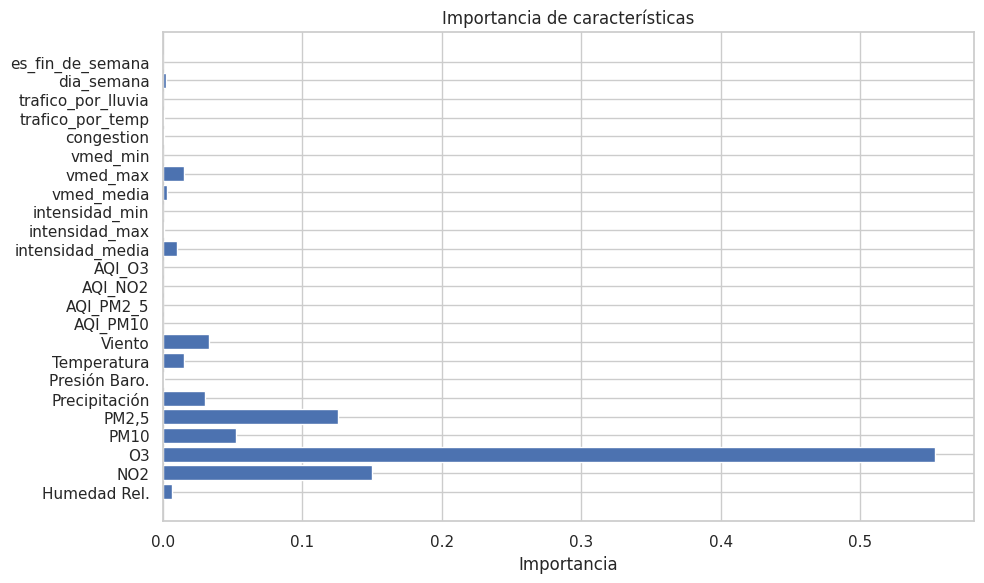

In [ ]:

# Extraer el modelo final del pipeline
modelo_final = best_model.named_steps['algoritmo']

# Obtener nombres de las características
features = X_train.columns

# Obtener importancias (solo si el modelo tiene el atributo)
if hasattr(modelo_final, "feature_importances_"):
    importances = modelo_final.feature_importances_

    # Visualizar
    plt.figure(figsize=(10, 6))
    plt.barh(features, importances)
    plt.xlabel("Importancia")
    plt.title("Importancia de características")
    plt.tight_layout()
    plt.show()
else:
    print("El modelo seleccionado no tiene 'feature_importances_'.")


In [ ]:
# Separación global
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Usa los mismos índices para sacar el contexto original
contexto = df_aqi_base_y_personalizado.loc[X_test.index, ['fecha', 'zona']]






In [ ]:
# Crear DataFrame de predicciones con contexto
df_predicciones = contexto.copy()
df_predicciones['AQI_predicho'] = y_pred
df_predicciones['fecha'] = pd.to_datetime(df_predicciones['fecha']).dt.date


In [ ]:
# Combinar predicciones de entrenamiento y prueba
df_aqi_base_y_personalizado['AQI_predicho'] = np.nan  # Inicializar columna
df_aqi_base_y_personalizado.loc[X_train.index, 'AQI_predicho'] = y_train_pred
df_aqi_base_y_personalizado.loc[X_test.index, 'AQI_predicho'] = y_pred

# Crear un DataFrame con todas las combinaciones de fechas y zonas
zonas = list(coordenadas_zonas.keys())
fechas = df_aqi_base_y_personalizado['fecha'].unique()
combinaciones = pd.DataFrame([(fecha, zona) for fecha in fechas for zona in zonas], columns=['fecha', 'zona'])

# Combinar con el DataFrame original para asegurarse de que todas las zonas estén representadas
df_completo = combinaciones.merge(df_aqi_base_y_personalizado, on=['fecha', 'zona'], how='left')

# Rellenar valores faltantes de AQI con un valor predeterminado (por ejemplo, 0 o NaN)
df_completo['AQI_predicho'] = df_completo['AQI_predicho'].fillna(0)

# Crear estructura GeoJSON con tiempo y colores en función del AQI
features = []

for _, row in df_completo.iterrows():
    zona = row['zona']
    aqi = row['AQI_predicho']
    fecha = row['fecha']

    # Obtener las coordenadas de la zona correspondiente
    coords = coordenadas_zonas.get(zona)

    # Asignar color según el valor de AQI_predicho
    if aqi <= 50:
        color = 'green'  # Bueno
    elif aqi <= 100:
        color = 'orange'  # Moderado
    else:
        color = 'red'  # Peligroso

    feature = {
        'type': 'Feature',
        'geometry': {
            'type': 'Point',
            'coordinates': [coords[1], coords[0]],  # Coordenadas (lon, lat)
        },
        'properties': {
            'time': fecha.strftime('%Y-%m-%d'),  # Fecha
            'popup': f"{zona}<br>AQI: {aqi:.1f}",  # Popup con AQI y zona
            'style': {'color': color},  # Color del marcador
            'icon': 'circle',
            'iconstyle': {
                'fillColor': color,  # Color de fondo según el AQI
                'fillOpacity': 0.6,  # Opacidad del marcador
                'stroke': 'true',
                'radius': 10
            }
        }
    }
    features.append(feature)

# Crear el objeto GeoJSON
geojson_data = {
    'type': 'FeatureCollection',
    'features': features
}

# Crear mapa
m = folium.Map(location=[40.4168, -3.7038], zoom_start=11)

# Añadir datos temporales con GeoJSON
TimestampedGeoJson(
    geojson_data,
    transition_time=200,
    period='P1D',
    add_last_point=True,
    auto_play=False,
    loop=False,
    max_speed=1,
    loop_button=True,
    date_options='YYYY-MM-DD',
    time_slider_drag_update=True
).add_to(m)

# Mostrar mapa
m

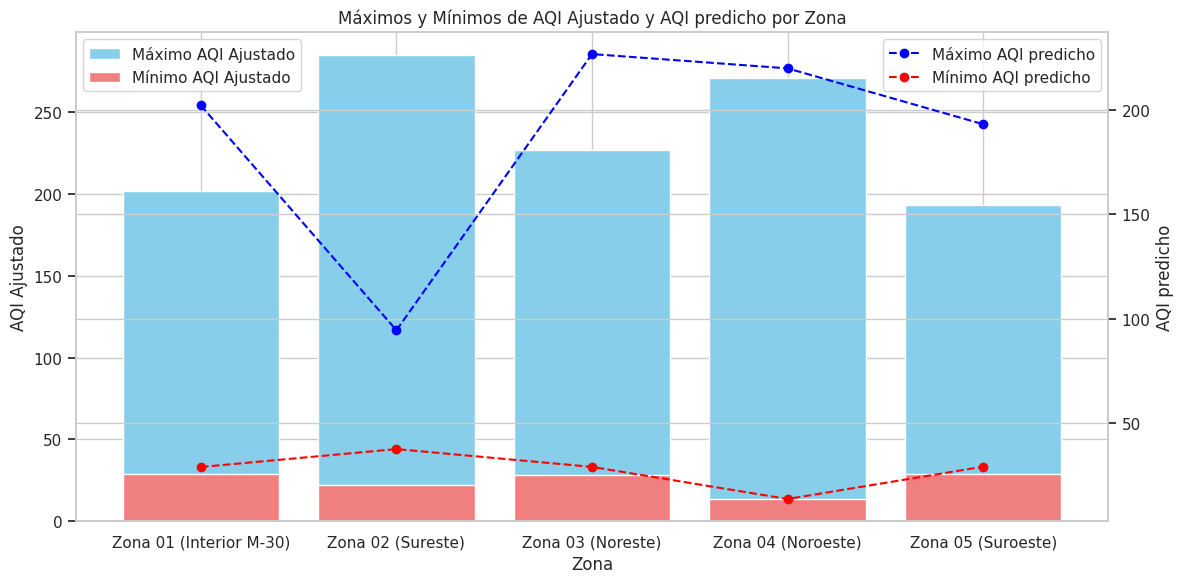

In [ ]:
# prompt: visualizar los maximos y minimos del aqi predicho y del aqi ajustado

# Importa la librería necesaria para visualizar
import matplotlib.pyplot as plt

# Calcula los máximos y mínimos del AQI predicho y ajustado por zona
aqi_stats = df_aqi_base_y_personalizado.groupby('zona')['AQI_ajustado'].agg(['max', 'min'])
aqi_stats1 = df_aqi_base_y_personalizado.groupby('zona')['AQI_predicho'].agg(['max', 'min'])

# Crea una figura y un eje para el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Crea barras para los máximos del AQI ajustado
ax.bar(aqi_stats.index, aqi_stats['max'], label='Máximo AQI Ajustado', color='skyblue')

# Crea barras para los mínimos del AQI ajustado
ax.bar(aqi_stats.index, aqi_stats['min'], label='Mínimo AQI Ajustado', color='lightcoral')

# Crea el segundo eje y
ax2 = ax.twinx()

# Dibuja las líneas para el máximo y mínimo del AQI diario
ax2.plot(aqi_stats1.index, aqi_stats1['max'], label='Máximo AQI predicho', color='blue', linestyle='--', marker='o')
ax2.plot(aqi_stats1.index, aqi_stats1['min'], label='Mínimo AQI predicho', color='red', linestyle='--', marker='o')


# Configura las etiquetas, leyendas y título del gráfico
ax.set_xlabel("Zona")
ax.set_ylabel("AQI Ajustado")
ax2.set_ylabel("AQI predicho")
ax.set_title("Máximos y Mínimos de AQI Ajustado y AQI predicho por Zona")
ax.legend(loc='upper left')
ax2.legend(loc='upper right')

# Ajusta el espaciado entre las barras y el texto de las etiquetas
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Muestra el gráfico
plt.show()


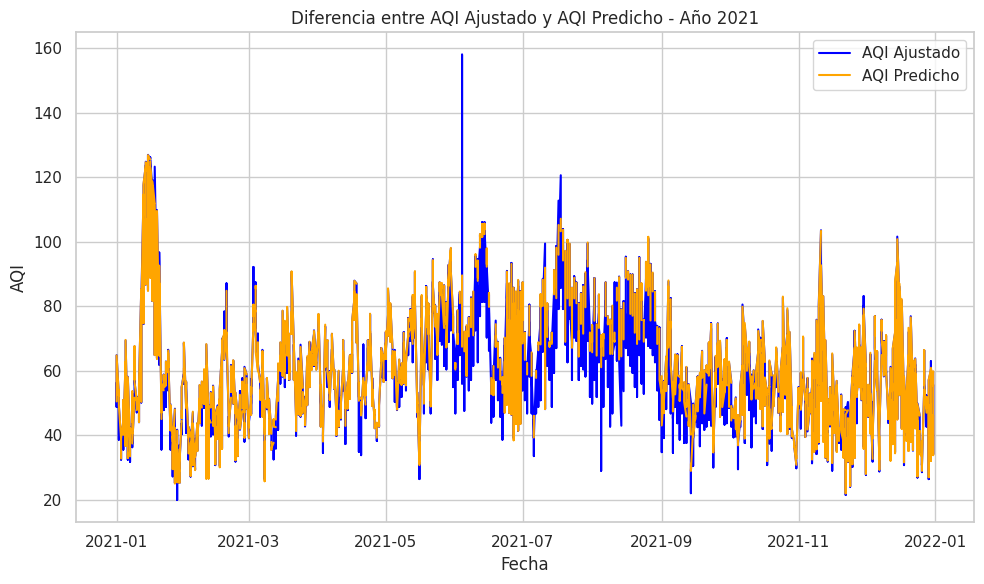

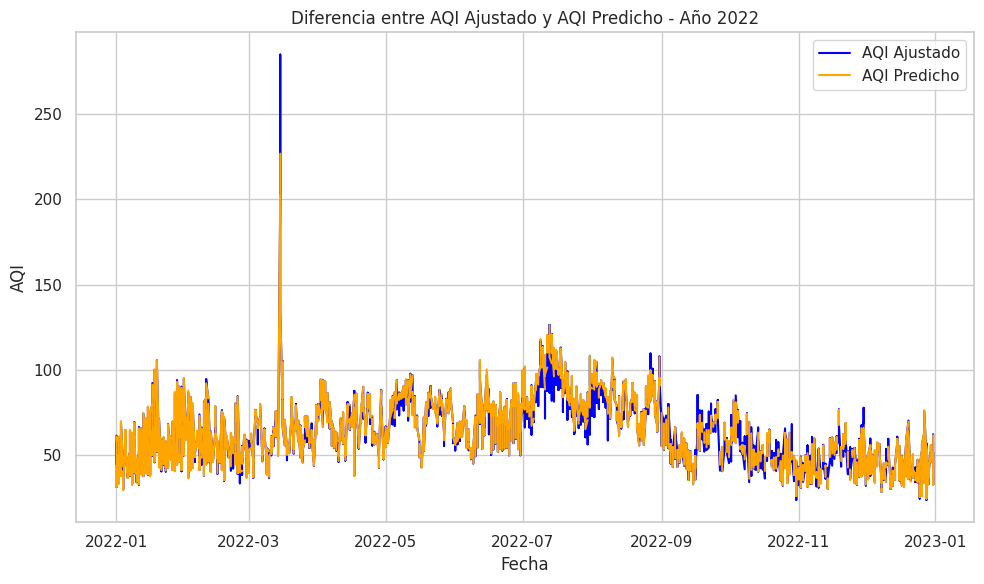

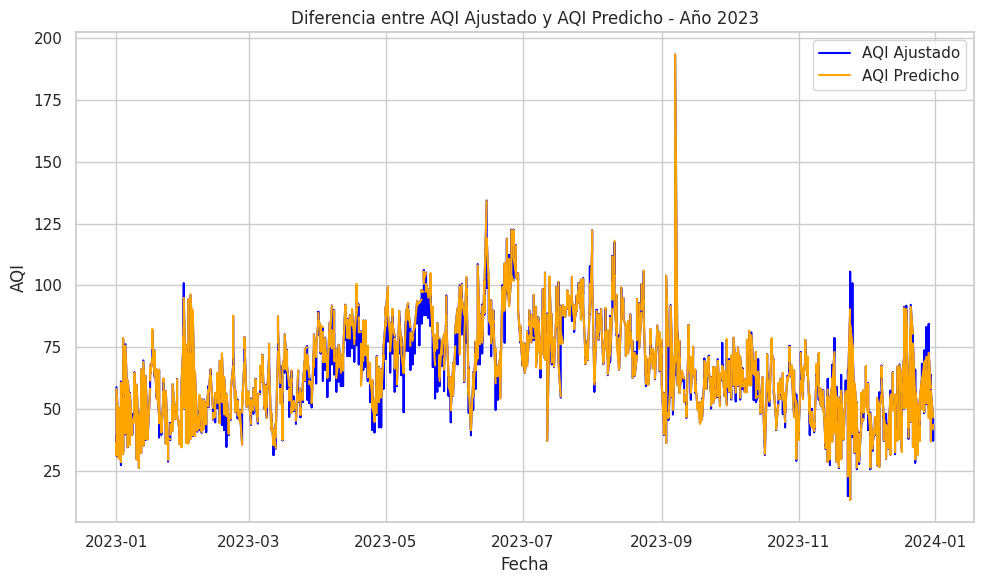

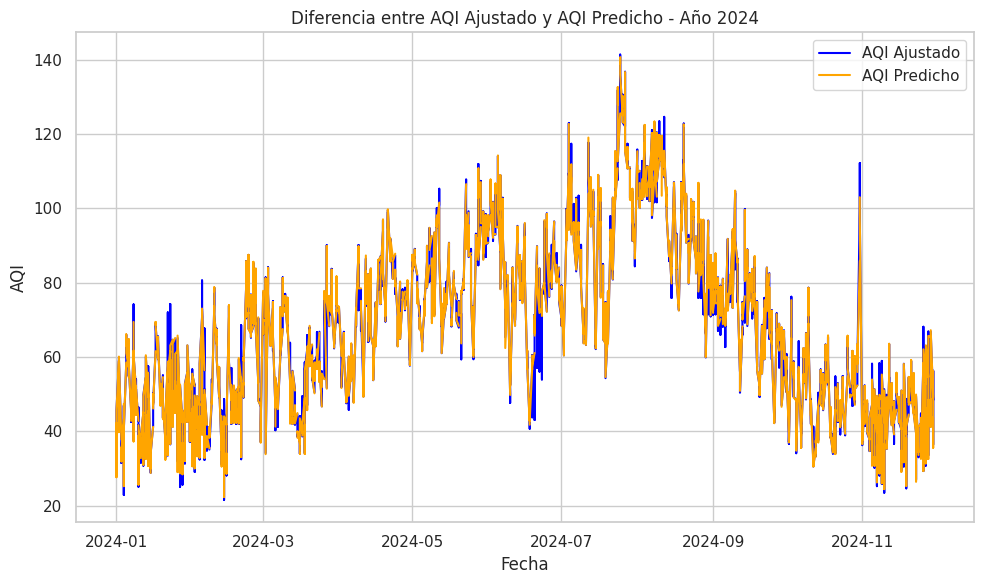

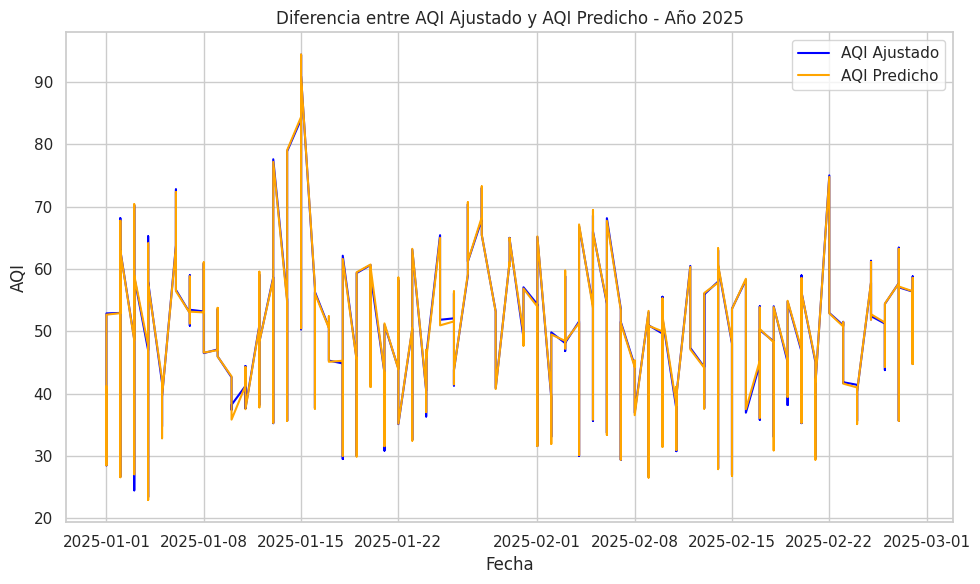

In [ ]:
import matplotlib.pyplot as plt

# Asegurarse de que la columna 'fecha' esté en formato datetime
df_aqi_base_y_personalizado['fecha'] = pd.to_datetime(df_aqi_base_y_personalizado['fecha'])

# Agregar una columna para el año
df_aqi_base_y_personalizado['año'] = df_aqi_base_y_personalizado['fecha'].dt.year

# Crear un gráfico por cada año
años = df_aqi_base_y_personalizado['año'].unique()

for año in años:
    df_año = df_aqi_base_y_personalizado[df_aqi_base_y_personalizado['año'] == año]

    plt.figure(figsize=(10, 6))
    plt.plot(df_año['fecha'], df_año['AQI_ajustado'], label='AQI Ajustado', color='blue')
    plt.plot(df_año['fecha'], df_año['AQI_predicho'], label='AQI Predicho', color='orange')
    plt.title(f'Diferencia entre AQI Ajustado y AQI Predicho - Año {año}')
    plt.xlabel('Fecha')
    plt.ylabel('AQI')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### **Resumen de las Gráficas de Visualización**

1. **Importancia de Características (Feature Importance)**
    - Se presenta un gráfico de barras horizontal que muestra la importancia relativa de cada variable predictora utilizada por el modelo final (por ejemplo, Random Forest). Este gráfico permite identificar cuáles son los factores más influyentes en la predicción del AQI ajustado, destacando la relevancia de contaminantes, variables meteorológicas y de tráfico.

2. **Máximos y Mínimos de AQI Ajustado y AQI Predicho por Zona**
    - Se utiliza un gráfico combinado de barras y líneas para comparar los valores máximos y mínimos del AQI ajustado (calculado con multiplicadores heurísticos) y del AQI predicho por el modelo, agrupados por zona geográfica. Esta visualización facilita la comparación entre el comportamiento real y el estimado del índice de calidad del aire en cada zona de Madrid.

3. **Evolución Temporal del AQI Ajustado y Predicho por Año**
    - Para cada año disponible en el dataset, se genera un gráfico de líneas que muestra la evolución diaria del AQI ajustado y del AQI predicho. Esto permite analizar tendencias, identificar picos de contaminación y evaluar la capacidad del modelo para seguir la dinámica temporal del AQI en diferentes periodos.

4. **Mapa Interactivo Espacio-Temporal del AQI Predicho**
    - Se crea un mapa interactivo de Madrid donde, para cada fecha y zona, se visualiza el valor del AQI predicho mediante marcadores de colores (verde, naranja, rojo) según el nivel de contaminación. El mapa permite explorar la evolución espacial y temporal del AQI, facilitando la identificación de zonas y periodos críticos de contaminación.

---

Estas visualizaciones permiten interpretar de manera integral los resultados del modelo, comparar predicciones con valores ajustados y analizar la distribución espacial y temporal de la calidad del aire en Madrid.

In [ ]:
from joblib import dump

# Guardar el mejor modelo en un archivo
dump(best_model, 'mejor_modelo_predictivo.joblib')

print("El modelo ha sido guardado exitosamente.")

El modelo ha sido guardado exitosamente.


In [ ]:
# guardar el df_aqi_base_y_personalizado en un .csv
df_aqi_base_y_personalizado.to_csv('df_aqi_base_y_personalizado.csv', encoding='utf-8', index=False)
from google.colab import files # Asegúrate de que files esté importado
files.download('df_aqi_base_y_personalizado.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files

# Guardar el mapa en un archivo HTML
m.save('mapa_aqi.html')

# Descargar el archivo HTML
files.download('mapa_aqi.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **🎯 Conclusiones AQI personalizado por zonas**

1. **Integración de Datos y Modelos Predictivos**:
    - Este trabajo demuestra cómo combinar datos provenientes de diversas fuentes, como meteorología, tráfico y calidad del aire,
    para predecir el Índice de Calidad del Aire Ajustado (AQI_ajustado). La integración de estas múltiples fuentes permitió capturar
    las interacciones complejas entre factores ambientales y humanos que afectan la calidad del aire. Este enfoque interdisciplinario
    resalta la importancia de unificar datos heterogéneos para obtener una visión más completa y precisa del problema.

2. **Impacto de Factores Ambientales y de Tráfico**:
    - Los ajustes heurísticos aplicados, basados en condiciones meteorológicas (como humedad, temperatura, precipitación y viento) y
    de tráfico (como intensidad de tráfico y velocidad media), demostraron ser efectivos para reflejar las condiciones reales que
    influyen en la calidad del aire. Estos ajustes permitieron incorporar sensibilidad ambiental al modelo, mejorando su capacidad
    para representar escenarios reales y dinámicos.

3. **Importancia de las Variables Predictoras**:
    - El análisis de importancia de características destacó que las variables relacionadas con contaminantes (PM10, PM2.5, NO2, O3),
    tráfico (intensidad_media, vmed_media) y meteorología (temperatura, humedad, viento) fueron determinantes para predecir el AQI.
    Este hallazgo subraya la necesidad de monitorear estas variables de manera continua y precisa, ya que tienen un impacto directo
    en la calidad del aire y, por ende, en la salud pública.

4. **Desempeño del Modelo**:
    - El modelo predictivo seleccionado, optimizado mediante técnicas avanzadas como GridSearchCV, logró un desempeño sólido en términos
    de métricas como (RMSE: 2.76 y R² Score: 0.98). Un RMSE bajo y un R² cercano a 1 indican que el modelo tiene un excelente ajuste y
    capacidad predictiva sobre el AQI ajustado. La redacción refleja adecuadamente el buen desempeño del modelo y su utilidad para la
    predicción y análisis de la calidad del aire.

5. **Visualización y Análisis Espacial**:
    - La creación de mapas interactivos y gráficos temporales permitió analizar las variaciones del AQI en diferentes zonas y fechas.
    Estas visualizaciones no solo facilitaron la interpretación de los resultados, sino que también proporcionaron una herramienta
    poderosa para la toma de decisiones informadas y la comunicación efectiva de los hallazgos a diferentes audiencias, incluidas
    autoridades locales y el público en general.

6. **Limitaciones y Oportunidades de Mejora**:
    - A pesar de los logros alcanzados, el modelo enfrenta ciertas limitaciones. La falta de datos completos para algunos contaminantes
    clave, como CO y SO2, restringió su inclusión en las predicciones, lo que podría haber afectado la precisión general del modelo.

7. **Aplicaciones Prácticas**:
    - Este enfoque tiene un gran potencial para ser utilizado por autoridades locales y organismos reguladores. Puede servir como una
    herramienta para monitorear y predecir la calidad del aire, identificar áreas críticas con altos niveles de contaminación y planificar
    intervenciones específicas, como restricciones de tráfico, campañas de concienciación o medidas de mitigación. Además, su capacidad
    para integrar datos en tiempo real lo convierte en una solución adaptable para escenarios dinámicos.

8. **Contribución a la Gestión de la Calidad del Aire**:
    - Este trabajo combina ciencia de datos, aprendizaje automático y visualización para abordar un problema crítico de salud pública.
    Proporciona una base sólida para futuras investigaciones y aplicaciones en la gestión de la calidad del aire, destacando cómo la
    tecnología y los datos pueden ser aliados clave en la lucha contra la contaminación y sus efectos adversos en la salud humana y el
    medio ambiente.

En resumen, este proyecto representa un avance significativo en la integración de datos y modelos predictivos para la gestión de la calidad
del aire. Su enfoque innovador y sus resultados prometedores sientan las bases para futuras mejoras y aplicaciones prácticas en la protección
de la salud pública y el medio ambiente.